In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# Clases

In [2]:
class Datos(Dataset): 
    def __init__(self, imagenes, etiquetas):
        """
        Convierte los datos originales a tensores de Pytorch.
        
        Parameters
        --------------
        imagenes:
            Son las imagenes del dataset.
        etiquetas:
            Son las etiquetas que se usan para la calsificación
        
        Returns
        -------------
        No devuelve nada.
        """
        self.imagenes = torch.tensor(imagenes, dtype=torch.float32)
        self.etiquetas = torch.tensor(etiquetas, dtype=torch.float32)

    def __len__(self):
        """
        Calcula la cantidad de muestras de la base.
        
        Parameters
        --------------
        No recibe parámetros.
        
        Returns
        -------------
        len(self.imagenes):
            Numero total de muestras.
        """
        return len(self.imagenes)
    
    def set_imagen(self, idx, nueva_imagen):
        """
        Reemplaza la imagen en el índice dado con una nueva imagen.
        
        Parameters
        ----------
        idx : int
            Índice de la imagen a modificar.
        nueva_imagen : torch.Tensor
            Nueva imagen que reemplazará a la existente.
        """
        self.imagenes[idx] = nueva_imagen

    def set_etiqueta(self, idx, nueva_etiqueta):
        """
        Reemplaza la etiqueta en el índice dado con una nueva etiqueta.
        
        Parameters
        ----------
        idx : int
            Índice de la etiqueta a modificar.
        nueva_etiqueta : torch.Tensor
            Nueva etiqueta que reemplazará a la existente.
        """
        self.etiquetas[idx] = nueva_etiqueta
        
    def __getitem__(self, idx):
        """
        Obtener la imagen y la etiqueta de una imagen en específico.
        
        Parameters
        --------------
        idx:
            Indice de la imagen a recuperar.
        
        Returns
        -------------
        self.imagenes[idx]:
            Imagen del indice idx.
        self.etiquetas[idx]:
            Etiqueta de la imagen en el indice idx.
        """
        return self.imagenes[idx], self.etiquetas[idx]

In [3]:
# Definir el modelo
class RedNeuronal(nn.Module):
    """
    Red neuronal multicapa simple para clasificación binaria.
    Toma como entrada imágenes en escala de grises de 28x28 píxeles.
    """

    def __init__(self):
        """
        Constructor de la red neuronal.
        Define la arquitectura de la red como una secuencia de capas lineales y funciones de activación ReLU.
        """
        super().__init__()  # Llama a nn.Module para heredar correctamente
        self.net = nn.Sequential(
            nn.Flatten(),                  # Convierte (1, 28, 28) → (784)
            nn.Linear(28 * 28, 64),        # 784 → 64
            nn.ReLU(),
            nn.Linear(64, 32),             # 64 → 32
            nn.ReLU(),
            nn.Linear(32, 16),             # 32 → 16
            nn.ReLU(),
            nn.Linear(16, 1)               # 16 → 1 (salida binaria sin activación final)
        )

    def forward(self, x):
        """
        Define el paso hacia adelante (forward) de la red.
        
        Parameters
        ----------
        x : torch.Tensor
            Tensor de entrada con forma (batch_size, 1, 28, 28)

        Returns
        -------
        torch.Tensor
            Salida del modelo con forma (batch_size,)
        """
        return self.net(x).squeeze(1)  # Elimina dimensión extra de salida (batch_size, 1) → (batch_size,)

# Implementación

In [4]:
#Se cargan los datos 28 x 28
data = np.load("chestmnist.npz")

# Función para convertir etiquetas multiclase a binaria
def etiquetas_binarias(etiquetas):
    """
    Convierte etiquetas multiclase/multietiqueta en etiquetas binarias.

    Parameters
    ----------
    etiquetas : numpy.ndarray
        Etiquetas originales de 0 y 1 donde 1 indica la presencia de una enefermedad

    Returns
    -------
    numpy.ndarray
        Arreglo con valores 0.0 o 1.0 indicando si la muestra tiene al menos una enfermedad
    """
    return (etiquetas.sum(axis=1) > 0).astype(np.float32)


# Imágenes y etiquetas
X_train = data['train_images']
y_train = etiquetas_binarias(data['train_labels'])

X_test = data['test_images']
y_test = etiquetas_binarias(data['test_labels'])

# Agregar canal (1, H, W) pra poder usar Pytorch 
X_train = X_train[:, np.newaxis, :, :] #np.newaxis agregra una dimensión al arreglo
X_test = X_test[:, np.newaxis, :, :] 

# Convertir los datos a tensores
train_dataset = Datos(X_train, y_train)
test_dataset = Datos(X_test, y_test)

# Convertir los datos a DataLoaders para la implementación del modelo
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [5]:
# Crear el modelo
modelo = RedNeuronal()

# Definir función de costo con pesos
peso = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()], dtype=torch.float32)
criterio = nn.BCEWithLogitsLoss(pos_weight=peso) 

# Definir forma de optimizar el modelo (optimizar función de costos)
optimizador = torch.optim.SGD(modelo.parameters(), lr=0.001)

# Entrenar el modelo
perdida_batch = []
batches_validos = 0

for epoch in range(150):
    modelo.train()
    perdida_total = 0
    for X_batch, y_batch in train_loader:
        optimizador.zero_grad() # Limpia los gradientes acumulados
        predicciones = modelo(X_batch) 
        perdida = criterio(predicciones, y_batch)
        perdida.backward() # Calcula el gradiente con respecto a cada parámetro del modelo
        optimizador.step() # Actualiza los parametros segun los gradientes
        perdida_total += perdida.item() # Perdida acumulada en esta iteraccion
    perdida_batch.append(perdida_total/len(train_loader))
    # print(f"Época {epoch+1} - Pérdida promedio: {perdida_total/len(train_loader):.4f}")
    

In [6]:
# Evaluar el modelo
modelo.eval()

pred_finales = []
probabilidades = []
etiquetas_reales = []

correctas = 0
total = 0

with torch.no_grad(): # Desactiva el cálculo de gradientes (se usan los optimos)
    for X_batch, y_batch in test_loader:
        predicciones = modelo(X_batch) # Valores entre 0 y 1 
        preds = (predicciones > 0.5).float() # Clasifica 1 si es mayor a 0.5
        
        correctas += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        
        probabilidades.extend(predicciones.numpy())
        pred_finales.extend(preds.numpy())
        etiquetas_reales.extend(y_batch.numpy())

# Resultados

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

         0.0     0.6664    0.6822    0.6742     11928
         1.0     0.6291    0.6122    0.6205     10505

    accuracy                         0.6494     22433
   macro avg     0.6477    0.6472    0.6474     22433
weighted avg     0.6489    0.6494    0.6491     22433



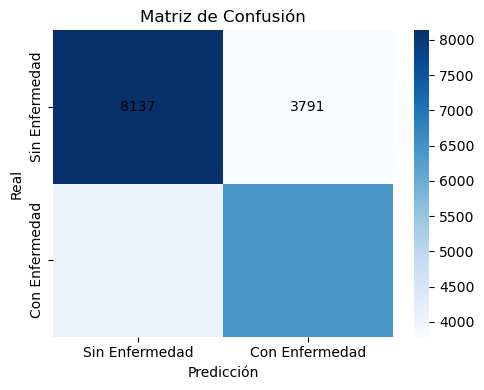

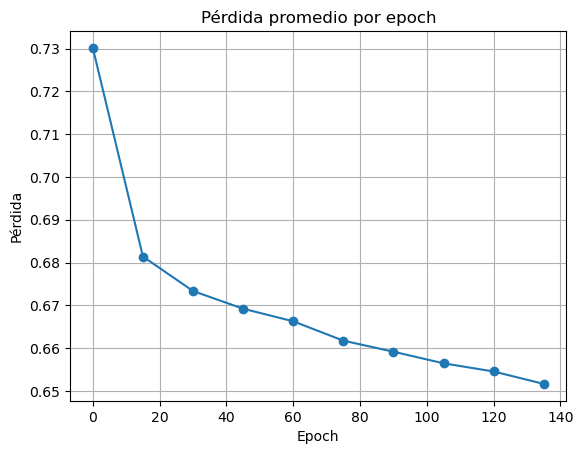

In [7]:
# Reporte de clasificación
print("=== Reporte de Clasificación ===")
print(classification_report(etiquetas_reales, pred_finales, digits=4))

# Matriz de confusión
conf_mat = confusion_matrix(etiquetas_reales, pred_finales)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            annot_kws={"color": "black"},
            xticklabels=["Sin Enfermedad", "Con Enfermedad"],
            yticklabels=["Sin Enfermedad", "Con Enfermedad"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Grafico de pérdidas en entrenamiento --ADVERTENCIA-- puede matar el kernel en jupyter

# Subconjunto de pérdida cada 20 epochs
subset = perdida_batch[::15]

# Crear los índices reales correspondientes (0, 15, 30, ...)
epochs = list(range(0, len(perdida_batch), 15))

plt.plot(epochs, subset, marker='o')
plt.title("Pérdida promedio por epoch")
plt.xlabel("Epoch")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()